In [1]:
%matplotlib inline

from collections import defaultdict
from itertools import permutations
from queue import Queue

import matplotlib.pyplot as plt
import numpy as np
import os

import pickle
import time

from random import choice, sample, shuffle

In [2]:
switch_literal = lambda x: x[1:] if x.startswith('-') else '-'+x
deepcopy = lambda x: pickle.loads(pickle.dumps(x))

def parse_input(input_file):
    
    """
    literal_clauseNum: {Literal: Set of clause numbers that are still in consideration for this variable}                        
    
    clauseNum_clause: {Clause number: Set of literals that could still satisfy this clause}
    
    literal_boolen: {Literal: boolean on whether literal set of True/False/None, None meaning could be either, doesn't matter}
    
    input_file:
    c DIMACS CNF: conjunction/AND of one or more clauses, where a clause is a disjunction/OR of literals
    c Comments start with a c, First lines begins with p and describes the probelm and all clause lines end with a 0
    c Can't have same variable in both forms in same clause. So A ~A is not allowed. Can have them in separate clauses.
                        
    """

    all_clauses = []  # List of all clauses that appear in input. Used for SAT checking the mapping given by DPLL

    literal_clauseNum = defaultdict(set)

    def filler():
        return None

    literal_boolen = defaultdict(filler)

    clauseNum_clause = {}

    clause_counter = 0

    with open(input_file, 'r') as fin:
        for line in fin:
            line = line.strip()
            # Do checks on comments
            if line.startswith('c') or line.startswith('p') or line.startswith('0') or line.startswith('%'):
                continue
            if len(line) > 0:
                clause = []
                clause_counter += 1
                for literal in line.split():
                    if literal == '0':
                        # End of line, ignore in DIMACS CNF format
                        continue
                    clause.append(literal)
                    literal_clauseNum[literal].add(clause_counter)
                clauseNum_clause[clause_counter] = set(clause)
                all_clauses.append(clause)

    return literal_clauseNum, clauseNum_clause, literal_boolen, all_clauses

def unit_prop(literal_clauseNum, clauseNum_clause, literal_boolen):
    keep_updating = True
    while keep_updating:
        keep_updating = False # Assuming we've found all unit clauses
        for clauseNum in list(clauseNum_clause.keys()):
            if clauseNum not in clauseNum_clause:
                continue
            clause = clauseNum_clause[clauseNum]
            # Clause contains the remaining literals that could potentially satisfy this clause. 
            if len(clause) == 0:
                # Empty clause, so need to return True for empty clause detected
                return True, None, None, None
            if len(clause) > 1:
                # Can't do unit prop 
                continue

            literal = clause.pop()  # Needs to be set to True
            clause.add(literal)  # Removed later
            literal_boolen[literal] = True
            keep_updating = True  # Since we found one unit clause, maybe more

    #         print(literal)
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)

            # For all clauses that have this literal, they have been satisfied now
            # 1) Gather all pairs of (literals, clauseNum) that appear in these clauses so we can remove them from literal_clauseNum
            # 2) Delete these clauses from clauseNum_clause
            pairs_to_delete = []
            for clauseNums_with_literal in literal_clauseNum[literal]:
                for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
                    pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

    #         print(pairs_to_delete)

            for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
                literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
                if clauseNums_with_literal in clauseNum_clause:
                    del clauseNum_clause[clauseNums_with_literal]

            # For all the clauses with opposite literal, remove the literal from the clause
            if switch_literal(literal) not in literal_clauseNum: # if the opposite variable doesn't exist, skip
                continue

            opposite_literal = switch_literal(literal)
            literal_boolen[opposite_literal] = False

            for clauseNums_with_literal in literal_clauseNum[opposite_literal]:
                clauseNum_clause[clauseNums_with_literal].discard(opposite_literal)

            literal_clauseNum[opposite_literal] = set()  # It is not watching any clauses anymore

    #         print("OPPO")
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)
        
    return False, literal_clauseNum, clauseNum_clause, literal_boolen


def pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen):
    for literal in list(literal_clauseNum.keys()):
        if literal in literal_boolen:
            continue
        
        opposite_literal = switch_literal(literal)
        if opposite_literal not in literal_boolen: # The opposite variable has not been assigned yet
            # If it doesn't exist or it does but it doesn't have to satisfy any clauses
            if opposite_literal not in literal_clauseNum or len(literal_clauseNum[opposite_literal]) == 0:
                # LITERAL IS A PURE LITERAL
                literal_boolen[literal] = True
                
                # All the clauses that literal exists in has been made true, so remove the clauses and make literal watch no clause
                pairs_to_delete = []
                for clauseNums_with_literal in literal_clauseNum[literal]:
                    for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
                        pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

        #         print(pairs_to_delete)

                for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
                    literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
                    if clauseNums_with_literal in clauseNum_clause:
                        del clauseNum_clause[clauseNums_with_literal]
                        
    return literal_clauseNum, clauseNum_clause, literal_boolen


def maxo(literal_clauseNum, return_counts=False):
    literal_count = defaultdict(int)
    for literal, clauseNums in literal_clauseNum.items():
        literal_count[literal] = len(clauseNums)
    if return_counts:
        return literal_count
    
    max_lit = None
    max_count = 0
    for literal, count in literal_count.items():
        if count > max_count:
            max_count = count
            max_lit = literal
    return max_lit, max_count


def moms(literal_clauseNum, clauseNum_clause, return_counts=False):
    # Select the clausesNumbers for clauses of the smaller size
    least_size = min(map(len, clauseNum_clause.values()))
    literal_count = defaultdict(int)
    
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            if len(clauseNum_clause[clauseNum]) == least_size:
                # Each time a literal appears in a least-size clause we 
                # increment counter by 1
                literal_count[literal] += 1
    
    if return_counts:
        return literal_count
    
    max_lit = None
    max_count = 0
    for literal, count in literal_count.items():
        if count > max_count:
            max_count = count
            max_lit = literal
    return max_lit, max_count


def mams(literal_clauseNum, clauseNum_clause):
    maxo_ans = maxo(literal_clauseNum, return_counts=True)
    moms_ans = moms(literal_clauseNum, clauseNum_clause, return_counts=True)
    
    # MAXO would return the dict with most keys
    for literal in maxo_ans:
        maxo_ans[literal] += moms_ans[literal]
        # Since using defaultdict we add 0 if literal not in moms_ans
    
    max_lit = None
    max_count = 0
    for literal, count in maxo_ans.items():
        if count > max_count:
            max_count = count
            max_lit = literal
    
    return max_lit, max_count


def jw(literal_clauseNum, clauseNum_clause):
    literal_score = defaultdict(int)
    
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            clause = clauseNum_clause[clauseNum]
            literal_score[literal] += 2 ** -len(clause)
    
    max_lit = None
    max_score = 0
    for literal, score in literal_score.items():
        if score > max_score:
            max_score = score
            max_lit = literal
            
    return max_lit, max_score

def set_var(literal, boolean, literal_clauseNum, clauseNum_clause, literal_boolen):
    literal_boolen[literal] = boolean

    if boolean == False:
        literal = switch_literal(literal)
        literal_boolen[literal] = True
    
    # Unit-prop logic below
    pairs_to_delete = []
    for clauseNums_with_literal in literal_clauseNum[literal]:
        for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
            pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

    #         print(pairs_to_delete)

    for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
        literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
        if clauseNums_with_literal in clauseNum_clause:
            del clauseNum_clause[clauseNums_with_literal]

    # For all the clauses with opposite literal, remove the literal from the clause
    if switch_literal(literal) not in literal_clauseNum: # if the opposite variable doesn't exist, skip
        return literal_clauseNum, clauseNum_clause, literal_boolen

    opposite_literal = switch_literal(literal)
    literal_boolen[opposite_literal] = False

    for clauseNums_with_literal in literal_clauseNum[opposite_literal]:
        clauseNum_clause[clauseNums_with_literal].discard(opposite_literal)

    literal_clauseNum[opposite_literal] = set()  # It is not watching any clauses anymore

    #         print("OPPO")
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)
    
    return literal_clauseNum, clauseNum_clause, literal_boolen

def choose_var(literal_clauseNum, clauseNum_clause, literal_boolen, algo='maxo'):
    # Choosing the first literal every time
#     remaining_clauses = list(clauseNum_clause.values())
#     literal = remaining_clauses[0].pop()
#     remaining_clauses[0].add(literal)

    # Using heuristics
    if algo == 'maxo':
        literal, _ = maxo(literal_clauseNum)
    elif algo == 'moms':
        literal, _ = moms(literal_clauseNum, clauseNum_clause)
    elif algo == 'mams':
        literal, _ = mams(literal_clauseNum, clauseNum_clause)
    elif algo == 'jw':
        literal, _ = jw(literal_clauseNum, clauseNum_clause)

    return literal

In [3]:
class Env:
    
    def __init__(self, input_file, numVars):
        self.input_file = input_file
        self.stack = [] # We use a stack to hold the next states to explore. i.e. we do DFS as less memory requirements than BFS
        self.state = None
        self.actions = {0: 'maxo', 1: 'moms', 2: 'mams', 3: 'jw'}
        
        # For now we have 100 numeric variables
        self.varOrder = list(map(str, range(-numVars, numVars+1)))  # Ordering of the variables. e.g. -100 to 100 (incl)
        self.var_index = {var: idx for var, idx in zip(self.varOrder, range(len(self.varOrder)))}
    
    def reset(self):
        # Returns state
        literal_clauseNum, clauseNum_clause, literal_boolen, _ = parse_input(self.input_file)
        self.state = (literal_clauseNum, clauseNum_clause, literal_boolen)
        return self.get_state()
    
    def get_state(self):
        """
        Returns a 2D/3D state of total number of variables
        """
#         literal_clauseNum, clauseNum_clause, literal_boolen = self.state
#         state_grid = np.zeros((len(self.varOrder), len(self.varOrder), len(self.varOrder)))
        
#         for clauseNum, clause in clauseNum_clause.items():
#             clause = list(clause)
#             while len(clause) < 3:
#                 clause.append(0)
#             v1, v2, v3  = clause
#             v1, v2, v3 = int(v1), int(v2), int(v3)
#             perms = permutations([v1, v2, v3])
#             for x, y, z in perms:
#                 state_grid[x][y][z] = 1
                
#         return np.expand_dims(state_grid, 3)


        """ 2D below """
        literal_clauseNum, clauseNum_clause, literal_boolen = self.state
        state_grid = np.zeros((len(self.varOrder), len(self.varOrder)))
        
        for literal, clauseNums in literal_clauseNum.items():
            row_index = self.var_index[literal]
#             state_grid[row_index][row_index] = 1  # If a literal is present, then it should be included in the state
            clauses = []
            for clauseNum in clauseNums:
                clause = clauseNum_clause[clauseNum]
                clauses.append(clause)
        
            for clause in clauses:
                for other_literal in clause:
                    col_index = self.var_index[other_literal]
                    state_grid[row_index][col_index] = 1
                    
        return np.expand_dims(state_grid, 2)
    
        
    def step(self, action):
        """
        Returns: next_state_1, next_state_2, reward, done
        reward = 0 if reached a leaf node, 0 if not
        """
        literal_clauseNum, clauseNum_clause, literal_boolen = self.state
        
#         print("At start of step method")
#         print(literal_clauseNum)
#         print(literal_boolen)
        
        unassigned_nodes_start = len(list(filter(lambda x: len(x) > 0, literal_clauseNum.values())))
        
        # Do unit prop
        empty_clause, literal_clauseNum, clauseNum_clause, literal_boolen = \
            unit_prop(literal_clauseNum, clauseNum_clause, literal_boolen)
            
#         print("After unit prop")
#         print(literal_clauseNum)
#         print(literal_boolen)
#         print()
        
        if empty_clause:
            isEmpty = len(self.stack) == 0
            if not isEmpty:
                self.state = self.stack.pop()
            return 0, -1, isEmpty
        
        if clauseNum_clause == {}:
            return 0, 1, True
        
        # Do pure literal elimination
        literal_clauseNum, clauseNum_clause, literal_boolen = \
            pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen)
            
#         print("After literal elimination")
#         print(literal_clauseNum)
#         print(literal_boolen)
#         print()
            
        if clauseNum_clause == {}:
            return 0, 1, True
        
        literal = choose_var(literal_clauseNum, clauseNum_clause, literal_boolen, algo=self.actions[action])
        
        # Set the chosen literal to be True
        literal_clauseNum_T, clauseNum_clause_T, literal_boolen_T = \
            set_var(literal, True, deepcopy(literal_clauseNum), deepcopy(clauseNum_clause), dict(literal_boolen))
            
#         print("After setting", literal, "to True")
#         print(literal_clauseNum_T)
#         print(literal_boolen_T)
#         print()
        
#         unassigned_nodes_T = len(filter(lambda x: len(x) > 0, literal_clauseNum_T.values()))
        
#         # Do unit prop and pure literal elimnation and record the number of nodes assigned
#         empty_clause, literal_clauseNum, clauseNum_clause, literal_boolen = 
#             unit_prop(literal_clauseNum_T, clauseNum_clause_T, literal_boolen_T)
        
#         if empty_clause:
#             return 0, 0, unassigned_nodes_start, self.q.empty()
        
#         # Do pure literal elimination
#         literal_clauseNum, clauseNum_clause, literal_boolen = 
#             pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen)
            
#         if clauseNum_clause == {}:
#             return 0, 0, unassigned_nodes_start, True
        
        # Add new state to queue
        
        self.stack.append((literal_clauseNum_T, clauseNum_clause_T, literal_boolen_T))
        
        # Set the chosen literal to be False
        literal_clauseNum_F, clauseNum_clause_F, literal_boolen_F = \
            set_var(literal, False, literal_clauseNum, clauseNum_clause, literal_boolen)
            
#         print("After setting", literal, "to False")
#         print(literal_clauseNum_F)
#         print(literal_boolen_F)
#         print()
            
#         unassigned_nodes_F = len(filter(lambda x: len(x) > 0, literal_clauseNum_F.values()))
            
#         # Do unit prop and pure literal elimnation and record the number of nodes assigned
#         empty_clause, literal_clauseNum, clauseNum_clause, literal_boolen = 
#             unit_prop(literal_clauseNum_F, clauseNum_clause_F, literal_boolen_F)
        
#         if empty_clause:
#             return 0, 0, unassigned_nodes_start, self.q.empty()
        
#         # Do pure literal elimination
#         literal_clauseNum, clauseNum_clause, literal_boolen = 
#             pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen)
            
#         if clauseNum_clause == {}:
#             return 0, 0, unassigned_nodes_start, True

        # Add new state to queue
        
        self.state = (literal_clauseNum_F, clauseNum_clause_F, literal_boolen_F)
        
#         return get_state_representation(literal_clauseNum_T), -1, False
        return None, -1, False
        
        # Using unassigned_nodes_start - unassigned_nodes_end as cost has been > 0 in testing

In [4]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, BatchNormalization
from keras.utils.np_utils import to_categorical
import keras.backend as K
from keras.optimizers import Adam

import tensorflow as tf

/home/aks73/python/Python-3.5.1/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
class PolicyEstimator():
    
    def __init__(self, numVars, learning_rate=0.01, scope="policy_estimator"):
        self.create_2d_model(numVars)
        
        self.model = Model(inputs=self.input, outputs=self.output)
        
        self.action = K.placeholder(dtype=tf.int32, name='action')
        self.target = K.placeholder(dtype=tf.float32, name='targte')
        
        self.chosen_action_prob = K.gather(K.squeeze(self.output, axis=0), self.action)
        policy_grad_loss = -K.log(self.chosen_action_prob) * self.target
        
        entropy = -K.sum(self.output * K.log(self.output))
        
        self.loss = policy_grad_loss + (0.01 * -entropy)  # We minimise negative entropy
        
        self.optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate)
        self.train_op = self.optimiser.minimize(self.loss)
        
        
    def create_2d_model(self, numVars):
        rows, cols = numVars*2 + 1, numVars*2 + 1
        channels = 1
        h1_size = 128
        input_shape = (rows, cols, channels)
        
        self.input = Input(shape=input_shape)
        self.conv1 = Conv2D(16, (16, 16), activation='relu', padding='same', name='block1_conv1')(self.input)
        self.pool1 = MaxPooling2D()(self.conv1)
        
        self.conv2 = Conv2D(32, (8, 8), activation='relu', padding='same', name='block2_conv1')(self.pool1)
        self.pool2 = MaxPooling2D()(self.conv2)

        self.conv3 = Conv2D(64, (4, 4), activation='relu', padding='same', name='block3_conv1')(self.pool2)
        self.pool3 = MaxPooling2D()(self.conv3)

        self.flat = Flatten()(self.pool3)
        self.norm = BatchNormalization()(self.flat)
        
        self.h1 = Dense(h1_size, activation='sigmoid')(self.norm)
        self.output = Dense(actions, activation='softmax')(self.h1)
        
        
    def create_3d_model(self, numVars):
        rows, cols, depth = numVars*2 + 1, numVars*2 + 1, numVars*2 + 1
        channels = 1
        h1_size = 128
        input_shape = (rows, cols, depth, channels)
        
        self.input = Input(shape=input_shape)
        self.conv1 = Conv3D(16, (16, 16, 16), activation='relu', padding='same', name='block1_conv1')(self.input)
        self.pool1 = MaxPooling3D()(self.conv1)
        
        self.conv2 = Conv3D(32, (8, 8, 8), activation='relu', padding='same', name='block2_conv1')(self.pool1)
        self.pool2 = MaxPooling3D()(self.conv2)

        self.conv3 = Conv3D(64, (4, 4, 4), activation='relu', padding='same', name='block3_conv1')(self.pool2)
        self.pool3 = MaxPooling3D()(self.conv3)

        self.flat = Flatten()(self.pool3)
#         self.norm = BatchNormalization()(self.flat)
        
        self.h1 = Dense(h1_size, activation='sigmoid')(self.flat)
        self.output = Dense(actions, activation='softmax')(self.h1)
        
        
    def predict(self, state, sess=None):
        if len(self.input.shape) != len(state.shape):
            state = np.expand_dims(state, 0)
        return np.squeeze(self.model.predict(state))

    def update(self, state, target, action, sess=None):
        sess = tf.get_default_session()
        if len(self.input.shape) != len(state.shape):
            state = np.expand_dims(state, 0)
        _, loss = sess.run([self.train_op, self.loss], feed_dict={self.input: state, self.action: action, 
                                                                  self.target: target, K.learning_phase(): 1})
        return loss

In [6]:
class ValueEstimator():
    
    def __init__(self, numVars, learning_rate=0.1, scope="value_estimator"):
        self.create_2d_model(numVars)
        
        self.model = Model(inputs=self.input, outputs=self.output)
        self.model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate))
        
    
    def create_2d_model(self, numVars):
        rows, cols = numVars*2 + 1, numVars*2 + 1
        channels = 1
        input_shape = (rows, cols, channels)
        
        self.input = Input(shape=input_shape)
        self.conv1 = Conv2D(16, (16, 16), activation='relu', padding='same', name='block1_conv1')(self.input)
        self.pool1 = MaxPooling2D()(self.conv1)
        
        self.conv2 = Conv2D(32, (8, 8), activation='relu', padding='same', name='block2_conv1')(self.pool1)
        self.pool2 = MaxPooling2D()(self.conv2)

        self.conv3 = Conv2D(64, (4, 4), activation='relu', padding='same', name='block3_conv1')(self.pool2)
        self.pool3 = MaxPooling2D()(self.conv3)

        self.flat = Flatten()(self.pool3)
        self.norm = BatchNormalization()(self.flat)
        
        self.output = Dense(1, activation=None, kernel_initializer='zeros')(self.norm)
    
    
    def create_3d_model(self, numVars):
        rows, cols, depth = numVars*2 + 1, numVars*2 + 1, numVars*2 + 1
        channels = 1
        input_shape = (rows, cols, depth, channels)
        
        self.input = Input(shape=input_shape)
        self.conv1 = Conv3D(16, (16, 16, 16), activation='relu', padding='same', name='block1_conv1')(self.input)
        self.pool1 = MaxPooling3D()(self.conv1)
        
        self.conv2 = Conv3D(32, (8, 8, 8), activation='relu', padding='same', name='block2_conv1')(self.pool1)
        self.pool2 = MaxPooling3D()(self.conv2)

        self.conv3 = Conv3D(64, (4, 4, 4), activation='relu', padding='same', name='block3_conv1')(self.pool2)
        self.pool3 = MaxPooling3D()(self.conv3)

        self.flat = Flatten()(self.pool3)
#         self.norm = BatchNormalization()(self.flat)
        
        self.output = Dense(1, activation=None, kernel_initializer='zeros')(self.flat)
    
    def predict(self, state, sess=None):
        if len(self.input.shape) != len(state.shape):
            state = np.expand_dims(state, 0)
        return np.squeeze(self.model.predict(state))


    def update(self, state, target, sess=None):
        if len(self.input.shape) != len(state.shape):
            state = np.expand_dims(state, 0)
            
        target = np.array(target)
        if len(self.output.shape) != len(target.shape):
            target = np.expand_dims(target, 0)
        
        loss = self.model.train_on_batch(state, target)
        return loss

In [7]:
def actor_critic(filepaths, epochs, numVars, estimator_policy, estimator_value, discount_factor=1.0):
    
    time_taken = []
    rewards_received = []
    
    for epoch in range(epochs):
        print(epoch)
        
        epoch_time = 0
        epoch_reward = 0
        
        for i, path in enumerate(filepaths):
            
            if i % 100 == 0:
                print(i)
                
            env = Env(path, numVars)
            state = env.reset()
            
            while True:
                action_probs = estimator_policy.predict(state)
                action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
                _, reward, done = env.step(action)
                
                # Stats
                epoch_time += 1
                epoch_reward += reward
                
                if done:
                    td_target = reward
                    td_error = td_target - estimator_value.predict(state)
                    estimator_value.update(state, td_target)
                    estimator_policy.update(state, td_error, action)
                    break
                
                next_state = env.get_state()
                
                # Calculate TD Target
                value_next = estimator_value.predict(next_state)
                td_target = reward + discount_factor * value_next
                td_error = td_target - estimator_value.predict(state)

                # Update the value estimator
                estimator_value.update(state, td_target)

                # Update the policy estimator
                # using the td error as our advantage estimate
                estimator_policy.update(state, td_error, action)
                
                state = next_state
            
        time_taken.append(epoch_time)
        rewards_received.append(epoch_reward)
        
    return time_taken, rewards_received

In [13]:
actions = 4
N = None  # Total number of variable at the start, gets set after parsing the input file
numVars = 20

policy_estimator = PolicyEstimator(numVars)
value_estimator = ValueEstimator(numVars)

directory = '../Tests/SATLIB_20/'
files = os.listdir(directory)
shuffle(files) # Shuffles in-place
filepaths = list(map(lambda x: os.path.join(directory, x), files))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    time_taken, rewards_received = actor_critic(filepaths, 4, numVars, policy_estimator, value_estimator)

0
0
100
200
300
400
500
600
700
800
900
1
0
100
200
300
400
500
600
700
800
900
2
0
100
200
300
400
500
600
700
800
900
3
0
100
200
300
400
500
600
700
800
900


In [4]:
# with open('ac_metrics.pickle', 'rb') as fin:
#     time_taken, rewards_received = pickle.load(fin)

Text(0,0.5,'Time taken')

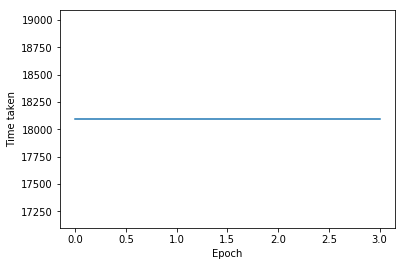

In [14]:
plt_avg = False

if plt_avg:
    time_taken_avg = np.array(time_taken) / 1000
    plt.plot(time_taken_avg)
else:
    plt.plot(time_taken)

plt.xlabel("Epoch")
plt.ylabel("Time taken")

Text(0,0.5,'Reward')

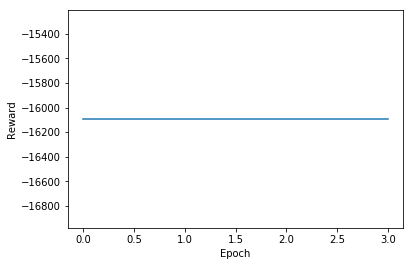

In [15]:
if plt_avg:
    reward_achieved_avg = np.array(rewards_received) / 1000
    plt.plot(reward_achieved_avg)
else:
    plt.plot(rewards_received)
    
plt.xlabel("Epoch")
plt.ylabel("Reward")